# Machine Learning Project 2024

## Part 1

The first part of this project is to use pre-existing models to transcribe audio files, while identifying who was speaking and when.

- Speaker Diarisation
- Speech to Text
- Analysis


In [25]:
import whisper
import os 
import csv
import pandas as pd
import matplotlib.pyplot as plt

Whisper requires the command line tool ffmpeg to be installed on the system. This needs to be done via a package manager like chocolatey for windows. This installs software packages at a system level. Options for other OS are listed in the README file. 




In [3]:
#define path

file_path = "data/raw/TrumpHarrisDebate.mp3"

#select whisper model

model = whisper.load_model("base")
result = model.transcribe(file_path)
print(result["text"])

c:\Users\kolea\anaconda3\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
c:\Users\k

 Thank you. Welcome to you both. It's wonderful to have you. It's an honor to have you both here tonight. We have inflation like very few people have ever seen before. Probably the worst in our nation's history. This has been a disaster for people, for the middle class, but for every class. Donald Trump left us the worst unemployment since the Great Depression. And what we have done is clean up Donald Trump's mess. She's a Marxist. Everybody knows she's a Marxist. Her father is a Marxist professor in economics. And he taught her well. But her vice presidential pick says abortion in the ninth month is absolutely fine. He also says execution after birth. It's execution no longer abortion because the baby is born is okay. And that's not okay with me. One does not have to abandon their face or deeply held back. Or deeply held beliefs to agree. The government and Donald Trump certainly should not be telling a woman what to do with her body. Pregnant women who want to carry a pregnancy to te

In [4]:
# Save the transcribed text file

transcriprtion = result["text"]

output_folder = "data/processed"
output_file = os.path.join(output_folder, "whisper_transcription.txt")
with open(output_file, "w") as file:
  file.write(transcriprtion)

The above code has transcribed the full interview to a txt file. However it does not identify the different speakers or separate their words.

In [5]:
#Using whisper to detect what language the audiofile is.sample

#get a 30s sample of the file
#sample = whisper.load_audio(file_path)
#sample = whisper.pad_or_trim(audio)


# make log-Mel spectrogram and move to the same device as the model
#mel = whisper.log_mel_spectrogram(audio, n_mels=model.dims.n_mels).to(model.device)

# detect the spoken language
#_, probs = model.detect_language(mel)
#print(f"Detected language: {max(probs, key=probs.get)}")

In [6]:
# decode the audio
#options = whisper.DecodingOptions()
#result = whisper.decode(model, mel, options)
#print(result.text)

In [7]:
from pyannote.audio import Pipeline
#https://github.com/pyannote/pyannote-audio/blob/develop/README.md

c:\Users\kolea\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [8]:
from Authtoken import token

In [9]:
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token=token)
diarisation = pipeline(file_path)

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
c:\Users\kolea\anaconda3\Lib\inspect.py:992: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\kolea\.cache\torch\pyannote\models--pyannote--segmentation\snapshots\c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b\pytorch_model.bin`
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/sp

Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.5.1+cpu. Bad things might happen unless you revert torch to 1.x.


c:\Users\kolea\anaconda3\Lib\site-packages\speechbrain\utils\autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
c:\Users\kolea\anaconda3\Lib\site-packages\speechbrain\utils\parameter_transfer.py:234: UserWarning: Requested Pretrainer collection using symlinks on Windows. This might not work; see `LocalStrategy` documentation. Consider unsetting `collect_in` in Pretrainer to avoid symlinking altogether.
  warnings.warn(
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb

In [18]:
# show each time someone spoke and output it to a csv

output_file = os.path.join(output_folder, "speaking_times.csv")
with open(output_file, "w", newline="") as csvfile: 
  writer = csv.writer(csvfile)
  #headings
  writer.writerow(['Speaker', 'Start Time (s)', 'End Time (s)'])
  for turn, _, speaker in diarisation.itertracks(yield_label=True):
      writer.writerow([speaker, f"{turn.start:.1f}", f"{turn.end:.1f}"])
      print(f"{speaker}: {turn.start:.1f}s to {turn.end:.1f}s")

SPEAKER_02: 1.7s to 5.3s
SPEAKER_00: 1.8s to 2.5s
SPEAKER_00: 6.6s to 10.2s
SPEAKER_01: 10.3s to 20.6s
SPEAKER_02: 21.0s to 29.8s
SPEAKER_01: 30.1s to 52.6s
SPEAKER_02: 52.8s to 82.5s
SPEAKER_01: 82.5s to 97.0s
SPEAKER_00: 97.0s to 102.5s
SPEAKER_01: 100.4s to 100.7s
SPEAKER_02: 100.7s to 101.2s
SPEAKER_02: 103.4s to 105.2s
SPEAKER_00: 106.3s to 111.9s
SPEAKER_01: 108.4s to 115.6s
SPEAKER_00: 115.6s to 128.2s
SPEAKER_02: 128.3s to 159.9s
SPEAKER_01: 159.9s to 175.0s
SPEAKER_02: 175.0s to 187.8s
SPEAKER_02: 189.3s to 190.5s
SPEAKER_01: 190.8s to 203.7s


### Data presentation

In [19]:
#import the csv file as a Dataframe to visualise

speaker_csv = "data/processed/speaking_times.csv"

speaker_df = pd.read_csv(speaker_csv)
speaker_df

,Speaker,Start Time (s),End Time (s)
0,SPEAKER_02,1.7,5.3
1,SPEAKER_00,1.8,2.5
2,SPEAKER_00,6.6,10.2
3,SPEAKER_01,10.3,20.6
4,SPEAKER_02,21.0,29.8
5,SPEAKER_01,30.1,52.6
6,SPEAKER_02,52.8,82.5
7,SPEAKER_01,82.5,97.0
8,SPEAKER_00,97.0,102.5
9,SPEAKER_01,100.4,100.7


In [21]:
speaker_df["Duration"] = (speaker_df['End Time (s)']- speaker_df['Start Time (s)'])
speaker_df

,Speaker,Start Time (s),End Time (s),Duration
0,SPEAKER_02,1.7,5.3,3.6
1,SPEAKER_00,1.8,2.5,0.7
2,SPEAKER_00,6.6,10.2,3.6
3,SPEAKER_01,10.3,20.6,10.3
4,SPEAKER_02,21.0,29.8,8.8
5,SPEAKER_01,30.1,52.6,22.5
6,SPEAKER_02,52.8,82.5,29.7
7,SPEAKER_01,82.5,97.0,14.5
8,SPEAKER_00,97.0,102.5,5.5
9,SPEAKER_01,100.4,100.7,0.3


In [28]:
#create separate datafrmae for each speaker
#speaker_00
speaker_0_df = speaker_df[speaker_df["Speaker"] == "SPEAKER_00"]

#speaker_01
speaker_1_df = speaker_df[speaker_df["Speaker"] == "SPEAKER_01"]

#speaker_02
speaker_2_df = speaker_df[speaker_df["Speaker"] == "SPEAKER_02"]

speaker_0_df

,Speaker,Start Time (s),End Time (s),Duration
1,SPEAKER_00,1.8,2.5,0.7
2,SPEAKER_00,6.6,10.2,3.6
8,SPEAKER_00,97.0,102.5,5.5
12,SPEAKER_00,106.3,111.9,5.6
14,SPEAKER_00,115.6,128.2,12.6


TypeError: 'str' object is not callable

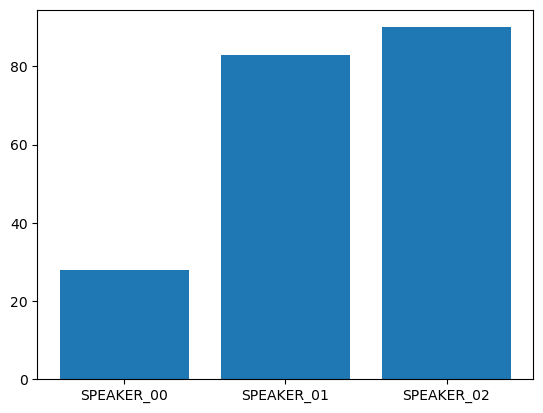

In [ ]:
#Plot them on bar chart to visualise the difference.

total_durations = {
  "SPEAKER_00": speaker_0_df["Duration"].sum(),  
  "SPEAKER_01": speaker_1_df["Duration"].sum(),
  "SPEAKER_02": speaker_2_df["Duration"].sum(),
} 

labels = list(total_durations.keys())
values = list(total_durations.values())

#create plot
plt.bar(labels, values)

plt.xlabel("Speakers")
plt.ylabel("Total Duration (seconds)")
plt.title("Total Speaking Duration per Speaker")

#Show plot
plt.show()

In [11]:
speaker_segments = {}

# Print speaker segments
for turn, _, speaker in diarisation.itertracks(yield_label=True):
    if speaker not in speaker_segments:
        speaker_segments[speaker]= []
    speaker_segments[speaker].append((turn.start, turn.end))

print(speaker_segments)

{'SPEAKER_02': [(1.70159375, 5.29596875), (20.95596875, 29.781593750000003), (52.782218750000006, 82.48221875), (100.69034375000001, 101.24721875), (103.44096875000001, 105.17909375), (128.28096875, 159.87096875), (174.95721875, 187.76534375), (189.25034375, 190.48221875000002)], 'SPEAKER_00': [(1.81971875, 2.5115937500000003), (6.64596875, 10.223468750000002), (97.02846875, 102.52971875), (106.29284375, 111.94596875), (115.62471875000001, 128.24721875)], 'SPEAKER_01': [(10.25721875, 20.61846875), (30.06846875, 52.63034375), (82.48221875, 97.02846875), (100.36971875, 100.69034375000001), (108.43596875, 115.62471875000001), (159.87096875, 174.95721875), (190.76909375000002, 203.69534375)]}
